# <center> Stochastic Optimization and Automatic Differentiation for Machine Learning<br/><br/>SDCA<br/><br/>Zakarya Ali</center>



In this notebook, I implement the **SDCA (Stochastic Dual Coordinate Ascent)** algorithm (from the article [Stochastic Dual Coordinate Ascent Methods for Regularized Loss Minimization by Shai Shalev-Shwartz  and Tong Zhang](http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf) to estimate Support Vector Machines. First, I apply the algorithm on randomly generated data, then I use a credit fraud dataset to compare **SDCA** compare it with **PEGASOS (Primal Estimated subGrAdient SOlver for SVM)**, a sub-gradient descent approach.

We use the following terms :
- $X_1,..,X_n \in \mathbb{R}^d$ are the explanatory variables for the n observations
- $y_1,..,y_n \in \{-1,1\}$  are the associated labels
- $ \lambda $ is the SDCA regularization term
- $ w \in \mathbb{R} $ is the parameter to optimize
- $ \phi_i(a)=max(0,1-y_ia) $ the Hinge loss linked to the SVM

# Utils

Here are some functions we will need along this notebook

In [1]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

np.random.seed(2018)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# To compute the sum of individual hinge losses :
def sum_hinge(y, X, w, n_samples):
    losses = np.fmax(np.zeros(n_samples), np.ones(n_samples) - (y * (X.dot(w))))
    return np.sum(losses)

In [3]:
# To get the accuracy of linear SVM for a given parameter w :
def get_accuracy(X, y, w):
    preds = np.dot(X, w)
    preds[preds > 0] = 1
    preds[preds < 0] = -1
    return accuracy_score(y, preds)

In [4]:
# Function to compare the convergence of various primal curves :
def comparaison_convergence_plot(histories, labels, ylim=[None, None]):
    f, ax = plt.subplots(1, figsize = (15,7))
    if (ylim != [None, None]):
        ax.set_ylim(ylim)
    for i in range(len(labels)) :
        plt.plot(histories[i], label = labels[i])
    plt.title("Convergence plot")
    plt.ylabel("Primal Objective")
    plt.xlabel("Iterations")
    plt.legend(loc="best")
    plt.show()

# I. Algorithms

## I.1. SDCA Implementation

In [5]:
# To get the primal parameter w associated to a dual parameter alpha :
def primal_param(X, alpha, lambd, n_samples):
    return (1 / (lambd * n_samples)) * (np.dot(np.transpose(X), alpha))

In [6]:
# Used for computing the update of SDCA (see the report) :
def get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w):
    A = (1 / (lambd * n_samples)) * (np.dot(np.transpose(X[q]), X[q]))
    B = np.dot(np.transpose(X[q]) , w)
    delta_alpha_tilde_q = (y[q] - B) / A
    return y[q] * max(0 , min(1 , y[q]*(delta_alpha_tilde_q + alpha[q]))) - alpha[q] 

In [7]:
def sdca_svm_random(X, y, n_samples, T_0, lambd, nb_epochs=50):

    # initialization of alpha to a vector of zeros
    alpha = np.zeros(n_samples)
    # initialization of histories
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambd, n_samples)

    # main loop : random sampling
    for t in range(n_samples * nb_epochs):
        # pick random sample
        q = np.random.randint(0, n_samples)
        # compute and apply SDCA update rule
        delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
        e = np.zeros(n_samples)
        e[q] = 1
        sdca_update = e * delta_alpha_q
        alpha = alpha + sdca_update
        w = primal_param(X, alpha, lambd, n_samples)

        # histories updates
        w_history.append(w)
        primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history
    
def sdca_svm_permutation(X, y, n_samples, T_0, lambd, nb_epochs=50):

    # initialization of alpha to a vector of zeros
    alpha = np.zeros(n_samples)
    # initialization of histories
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambd, n_samples)
    # main loop : permutation sampling
    count = 0
    for t in range(nb_epochs):
        perm = np.random.permutation(n_samples)
        for q in perm :
            # compute and apply SDCA update rule
            delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
            e = np.zeros(n_samples)
            e[q] = 1
            sdca_update = e * delta_alpha_q
            alpha = alpha + sdca_update
            w = primal_param(X, alpha, lambd, n_samples)

            # histories updates
            w_history.append(w)

            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
            count +=1

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

def sdca_svm_cyclic(X, y, n_samples, T_0, lambd, nb_epochs=50):

    # initialization of alpha to a vector of zeros
    alpha = np.zeros(n_samples)
    # initialization of histories
    w_history = []
    primal_history = []
    w = primal_param(X, alpha, lambd, n_samples)
    # main loop : cyclic sampling
    count = 0
    perm = np.random.permutation(n_samples)
    for t in range(nb_epochs):
        for q in perm :
            # compute and apply SDCA update rule
            delta_alpha_q = get_delta_alpha_q(X, y, alpha, q, lambd, n_samples, w)
            e = np.zeros(n_samples)
            e[q] = 1
            sdca_update = e * delta_alpha_q
            alpha = alpha + sdca_update
            w = primal_param(X, alpha, lambd, n_samples)

            # histories updates
            w_history.append(w)
            primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
            count +=1
                
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

## I.2. Pegasos implementation

Very similar to SGD except : 

1) We compute sub-gradients and not gradients at each steps 

2) The step size is always $\frac{1}{\lambda t}$

In [8]:
# Subgradient for the hinge-loss (partial because is it computed for only one individual q) :
def partial_sub_gradient(w, X, y, q, lambd):
    if ( y[q]*np.dot(w, X[q]) < 1 ):
        return lambd * w - y[q] * X[q]
    else:
        return lambd * w

In [9]:
def PEGASOS_SVM(X, y, n_samples, T_0, lambd, nb_epochs=50, proj=False):

    # initialization of w to a vector of zeros
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []
    
    # main loop
    for t in range(1, n_samples * nb_epochs):
        # compute Pegasos step size
        step_size = 1 / (lambd * t)
        # pick random sample
        q = np.random.randint(0, n_samples)
        # compute and apply Pegasos update rule
        w = w - step_size * partial_sub_gradient(w, X, y, q, lambd)
        # projection step (optional)
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambd) * np.linalg.norm(w))) * w
        # histories updates
        w_history.append(w)
        
        primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
        
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history

 ## I.3. Accelerated mini-batch SDCA implementation
For accelerated mini-batch SDCA, the smooth version of the hinge loss is used, unlike for SDCA and Pegasos

In [10]:
# Gradient of the smooth hinge loss :
def partial_gradient_smooth(w, X, y, q):
    if (0 <= y[q] * np.dot(X[q], w) <= 1 ):
        return (y[q] * np.dot(X[q], w) - 1) * y[q] * X[q]
    if (y[q] * np.dot(w, X[q]) < 0 ):
        return - y[q] * X[q]
    else:
        return np.zeros(X.shape[1])

In [11]:
def SDCA_SVM_mini_batch(X, y, n_samples, T_0, lambd, batch_size, theta=0.3, nb_epochs=50):

    # initialization of alpha and w to a vector of zeros
    alpha = np.zeros(shape = (X.shape[1], n_samples))
    bar_alpha = np.mean(alpha, axis=1)
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []

    # main loop
    for t in range(n_samples * nb_epochs):
        u = (1 - theta) * w + (theta / lambd) * bar_alpha
        # pick a random mini-batch (sampling)
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        alpha_dif = []
        # compute the update rule for all selected samples
        for q in batch:
            old_alpha_q = alpha[:,q].copy()
            alpha[:,q] = (1 - theta) * alpha[:,q] - theta * partial_gradient_smooth(u, X, y, q)
            alpha_dif.append(alpha[:,q] - old_alpha_q)
        # applying the update
        bar_alpha = bar_alpha + (1 / n_samples) * sum(alpha_dif, axis=0)
        w = (1 - theta) * w + (theta / lambd) * bar_alpha
        
        # histories updates
        w_history.append(w)
        primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)

    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history


## I.4. Mini-batch Pegasos implementation

In [12]:
def PEGASOS_SVM_mini_batch(X, y, n_samples, T_0, lambd, batch_size, nb_epochs=50, proj=False):

    # initialization of w to a vector of zeros
    w = np.zeros(X.shape[1])
    # initialization of histories
    w_history = []
    primal_history = []
    
    # main loop
    for t in range(1, n_samples * nb_epochs):
        # compute Pegasos step size
        step_size = 1 / (lambd * t)
        # pick random batch of samples
        batch = np.random.choice(np.arange(0, n_samples), batch_size, replace=False)
        sum_vect = []
        for q in batch:
            if (y[q] * np.dot(X[q], w) < 1):
                sum_vect.append(y[q] * X[q])
            else:
                sum_vect.append(np.zeros(X.shape[1]))
        # compute and apply mini-batch Pegasos update rule
        w = w - step_size * (lambd * w - (1 / batch_size) * sum(sum_vect, axis=0))
        # Projection step (optional)
        if (proj == True):
            w = min(1, 1 / (np.sqrt(lambd) * np.linalg.norm(w))) * w
        # histories updates
        w_history.append(w)
        primal_history.append(sum_hinge(y, X, w, n_samples) / n_samples + (lambd / 2) * np.linalg.norm(w)**2)
    
    return asarray(w_history[T_0:]).mean(axis = 0), w_history, primal_history


# II. Application: Simulated data

In [13]:
n_samples, n_features = 1000, 10
# Feature matrix
# First array is person number 1, second array is person number 2 etc
X = np.random.randn(n_samples, n_features)
# true parameter
beta = np.random.randn(n_features)
# Binary label vector
y = np.dot(X, beta) + np.random.randn(n_samples)
y[y > 0] = 1
y[y < 0] = -1

In [14]:
# Standardisation of features is required before SVM :
X_std = preprocessing.StandardScaler().fit_transform(X)

In [15]:
# Train test split for this dataset :
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)
n_samples_train = X_train.shape[0]

## II.1. SDCA

In [16]:
# Computing the parameters and the primal value for all variants of SDCA :
simu_opt_w_sdca_avg_r, simu_w_hist_sdca_avg_r, simu_primal_hist_sdca_avg_r = sdca_svm_random(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples)

simu_opt_w_sdca_avg_p, simu_w_hist_sdca_avg_p, simu_primal_hist_sdca_avg_p = sdca_svm_permutation(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples)

simu_opt_w_sdca_avg_c, simu_w_hist_sdca_avg_c, simu_primal_hist_sdca_avg_c = sdca_svm_cyclic(X_train, y_train,
                                                                            n_samples_train, T_0=50 * n_samples // 2,
                                                                            lambd=1 / n_samples)

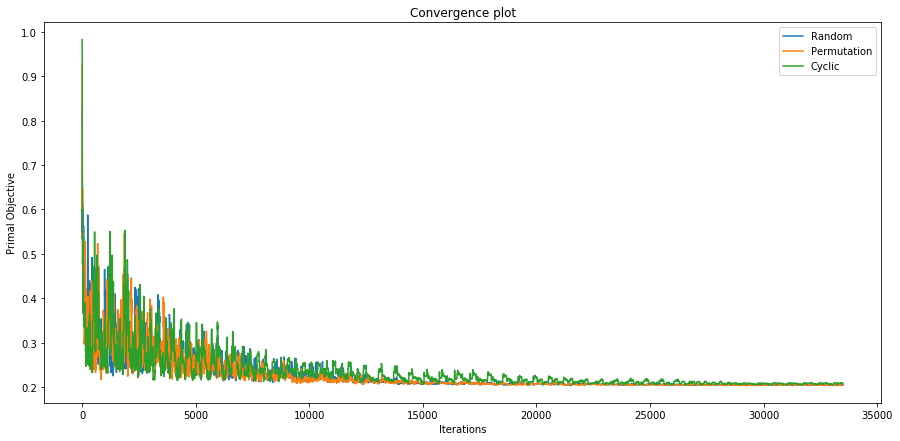

In [17]:
histories_simu_sdca = [simu_primal_hist_sdca_avg_r, simu_primal_hist_sdca_avg_p, simu_primal_hist_sdca_avg_c]
labels2_simu_sdca = ["Random", "Permutation", "Cyclic"]
comparaison_convergence_plot(histories_simu_sdca, labels2_simu_sdca)

In [18]:
# Computing prediction accuracy on test set
print("Random:", get_accuracy(X_test, y_test, simu_w_hist_sdca_avg_r[-1]))
print("Permutation:", get_accuracy(X_test, y_test, simu_w_hist_sdca_avg_p[-1]))
print("Cyclic:", get_accuracy(X_test, y_test, simu_w_hist_sdca_avg_c[-1]))
print("Average r:", get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_r))
print("Average p:", get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_p))
print("Average c:", get_accuracy(X_test, y_test, simu_opt_w_sdca_avg_c))
print("True:", get_accuracy(X_test, y_test, beta))

Random: 0.8515151515151516
Permutation: 0.8454545454545455
Cyclic: 0.8636363636363636
Average r: 0.8575757575757575
Average p: 0.8545454545454545
Average c: 0.8545454545454545
True: 0.8545454545454545


## II.2. Pegasos

In [19]:
# Computing the parameters and the primal value for all variants of Pegasos :
simu_opt_w_peg_avg, simu_w_hist_peg_avg, simu_primal_hist_peg_avg = PEGASOS_SVM(X_train, y_train,
                                                                    n_samples_train, T_0=50 * n_samples // 2,
                                                                    lambd=1 / n_samples, proj=False)

simu_opt_w_peg_avg_p, simu_w_hist_peg_avg_p, simu_primal_hist_peg_avg_p = PEGASOS_SVM(X_train, y_train,
                                                                        n_samples_train, T_0=50 * n_samples // 2,
                                                                        lambd=1 / n_samples, proj=True)

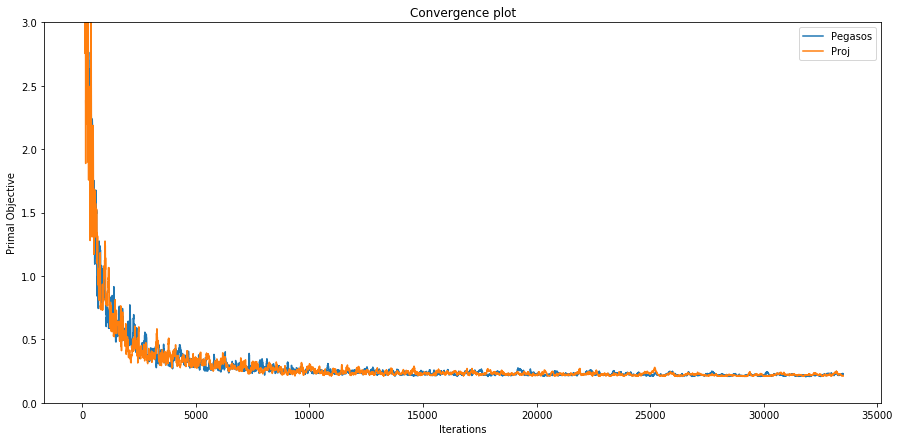

In [20]:
histories_simu_peg = [simu_primal_hist_peg_avg, simu_primal_hist_peg_avg_p]
labels2_simu_peg = ["Pegasos", "Proj"]
comparaison_convergence_plot(histories_simu_peg, labels2_simu_peg, ylim=[0,3])

In [21]:
# Computing prediction accuracy on test set
print("Pegasos", get_accuracy(X_test, y_test, simu_w_hist_peg_avg[-1]))
print("Projected", get_accuracy(X_test, y_test, simu_w_hist_peg_avg_p[-1]))
print("Average", get_accuracy(X_test, y_test, simu_opt_w_peg_avg))
print("Average p", get_accuracy(X_test, y_test, simu_opt_w_peg_avg_p))
print("True", get_accuracy(X_test, y_test, beta))

Pegasos 0.8454545454545455
Projected 0.8484848484848485
Average 0.8545454545454545
Average p 0.8575757575757575
True 0.8545454545454545


## II.3. Accelerated mini-batch SDCA

In [22]:
# Computing the parameters and the primal value for all variants of ASDCA :
simu_opt_w_sdca_batch_avg, simu_w_hist_sdca_batch_avg, simu_primal_hist_sdca_batch_avg = SDCA_SVM_mini_batch(X_train, y_train, n_samples_train, T_0=50 * n_samples // 2, lambd=1 / n_samples, batch_size = 8, theta = 0.15)

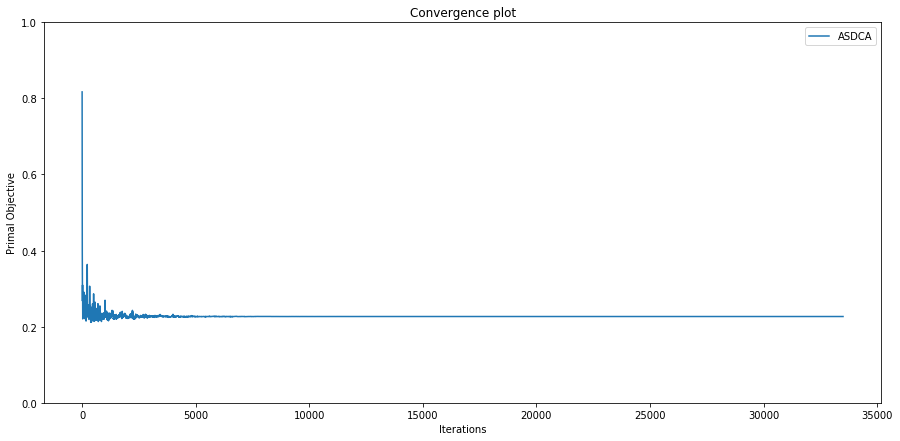

In [23]:
histories_simu_sdca_batch = [simu_primal_hist_sdca_batch_avg]
labels2_simu_sdca_batch = ["ASDCA"]
comparaison_convergence_plot(histories_simu_sdca_batch, labels2_simu_sdca_batch, ylim=[0,1])

In [24]:
# Computing prediction accuracy on test set
print("ASDCA", get_accuracy(X_test, y_test, simu_w_hist_sdca_batch_avg[-1]))
print("Average", get_accuracy(X_test, y_test, simu_opt_w_sdca_batch_avg))
print("True", get_accuracy(X_test, y_test, beta))

ASDCA 0.8606060606060606
Average 0.8606060606060606
True 0.8545454545454545


## II.4. Mini-batch Pegasos

In [25]:
# Computing the parameters and the primal value for all variants of mini-batch Pegasos :
simu_opt_w_peg_batch_avg, simu_w_hist_peg_batch_avg, simu_primal_hist_peg_batch_avg = PEGASOS_SVM_mini_batch(X_train,
                                                                    y_train, n_samples_train, T_0=50 * n_samples // 2,
                                                                    lambd=1 / n_samples, batch_size=8, proj=False)

simu_opt_w_peg_batch_avg_p, simu_w_hist_peg_batch_avg_p, simu_primal_hist_peg_batch_avg_p = PEGASOS_SVM_mini_batch(X_train, y_train, n_samples_train, T_0=50 * n_samples // 2, lambd=1 / n_samples, batch_size=8, proj=True)

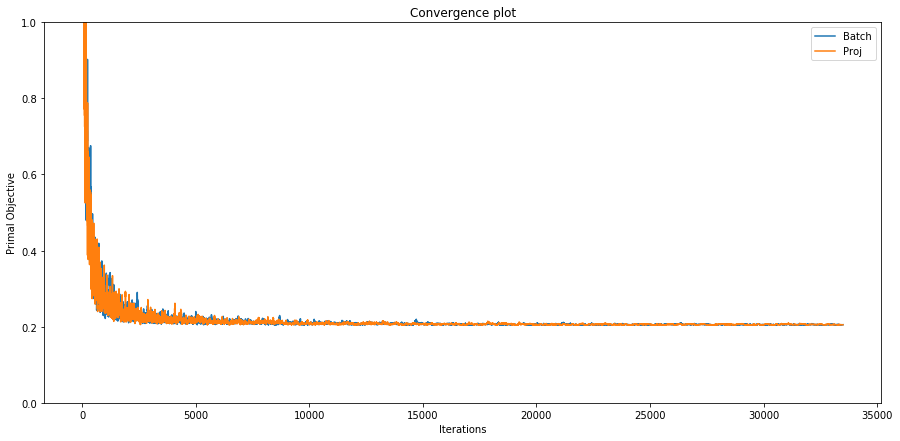

In [26]:
histories_simu_peg_batch = [simu_primal_hist_peg_batch_avg, simu_primal_hist_peg_batch_avg_p]
labels2_simu_peg_batch = ["Batch", "Proj"]
comparaison_convergence_plot(histories_simu_peg_batch, labels2_simu_peg_batch, ylim=[0,1])

In [27]:
# Computing prediction accuracy on test set
print("Batch", get_accuracy(X_test, y_test, simu_w_hist_peg_batch_avg[-1]))
print("Projected", get_accuracy(X_test, y_test, simu_w_hist_peg_batch_avg_p[-1]))
print("Average", get_accuracy(X_test, y_test, simu_opt_w_peg_batch_avg))
print("Average p", get_accuracy(X_test, y_test, simu_opt_w_peg_batch_avg_p))
print("True", get_accuracy(X_test, y_test, beta))

Batch 0.8545454545454545
Projected 0.8515151515151516
Average 0.8606060606060606
Average p 0.8575757575757575
True 0.8545454545454545


## II.5. Comparision between all four algorithms

In [28]:
# Accuracy omparison with the native sklearn learner :

# In the native implementation, the penalty parameter is C = 1 / (n_samples * lambda)
# Thus C = 1 (default in sklearn) is equivalent to lambda = 1 / n_samples
# hence the value that we chose for lambda in SDCA and pegasos

LSVM = svm.SVC(kernel = "linear")
model = LSVM.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

# Very close results (often exactly the same), sometimes SDCA or Pegasos beat the native implementation

0.8484848484848485

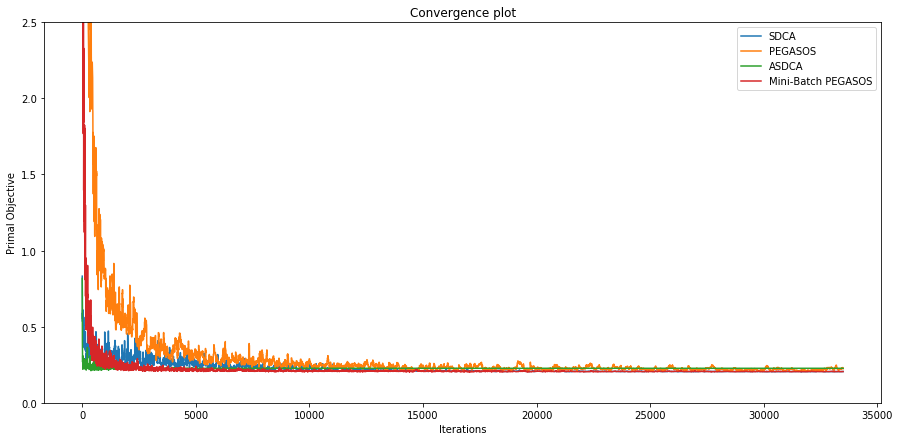

In [29]:
# Convergence comparison :

simu_histories = [simu_primal_hist_sdca_avg_r, simu_primal_hist_peg_avg,
                  simu_primal_hist_sdca_batch_avg, simu_primal_hist_peg_batch_avg]
simu_labels = ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"]
comparaison_convergence_plot(simu_histories, simu_labels, ylim = [0, 2.5])

# III. Application: Credit Fraud detection (highly unbalanced dataset)

This is a dataset from a Kaggle competition : https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [30]:
def rework_labels(label):
    result = label
    if label == 0:
        result = -1
    return result

data = pd.read_csv("data/creditcard.csv")
data = data.dropna()
print(data.shape)
X = data.drop(columns=["Class"])
y = data["Class"].apply(rework_labels)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Our dataset contain 30 features and 284807 observations.

In [31]:
X.shape

(284807, 30)

In [32]:
y.shape

(284807,)

In [33]:
# Standardisation of features is required before SVM :
X_std = preprocessing.StandardScaler().fit_transform(X)

In [34]:
# Train test split for this dataset :
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, stratify=y, random_state=2018)

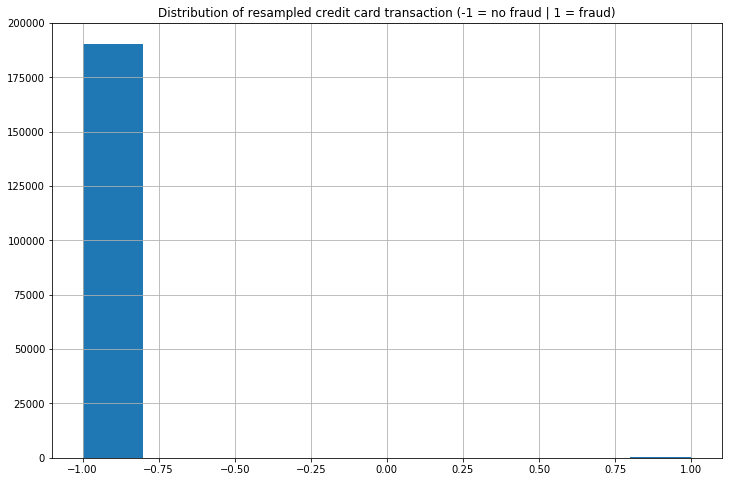

In [35]:
plt.figure(figsize=(12,8))
y_train.hist()
plt.title('Distribution of resampled credit card transaction (-1 = no fraud | 1 = fraud)')
plt.show()

The problem is highly unbalanced (0.175% of credit fraud in the dataset)

We undersample the majority class in order to get a better 

In [36]:
rus = RandomUnderSampler(random_state=42, ratio={-1: 1000})
X_res, y_res = rus.fit_sample(X_train, y_train)
n_samples = X_res.shape[0]

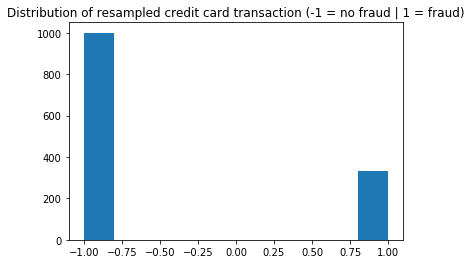

In [37]:
plt.hist(y_res)
plt.title('Distribution of resampled credit card transaction (-1 = no fraud | 1 = fraud)')
plt.show()

In [38]:
y_res.shape

(1330,)

In [39]:
X_res.shape

(1330, 30)

## III.1. SDCA

In [40]:
gen_opt_w_sdca_avg_r, gen_w_hist_sdca_avg_r, gen_primal_hist_sdca_avg_r = sdca_svm_random(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50) 
gen_opt_w_sdca_avg_p, gen_w_hist_sdca_avg_p, gen_primal_hist_sdca_avg_p = sdca_svm_permutation(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50)
gen_opt_w_sdca_avg_c, gen_w_hist_sdca_avg_c, gen_primal_hist_sdca_avg_c = sdca_svm_cyclic(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50)

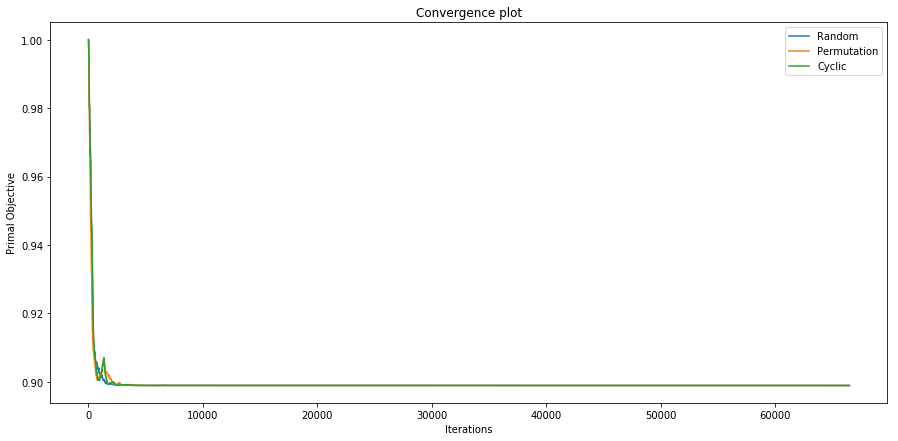

In [41]:
histories_gen_sdca = [gen_primal_hist_sdca_avg_r, gen_primal_hist_sdca_avg_p, gen_primal_hist_sdca_avg_c]
labels_gen_sdca = ["Random", "Permutation", "Cyclic"]
comparaison_convergence_plot(histories_gen_sdca, labels_gen_sdca)

## III.2. Pegasos

In [42]:
gen_opt_w_peg_avg, gen_w_hist_peg_avg, gen_primal_hist_peg_avg = PEGASOS_SVM(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50, proj=False)
gen_opt_w_peg_avg_proj, gen_w_hist_peg_avg_proj, gen_primal_hist_peg_avg_proj = PEGASOS_SVM(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50, proj=True)

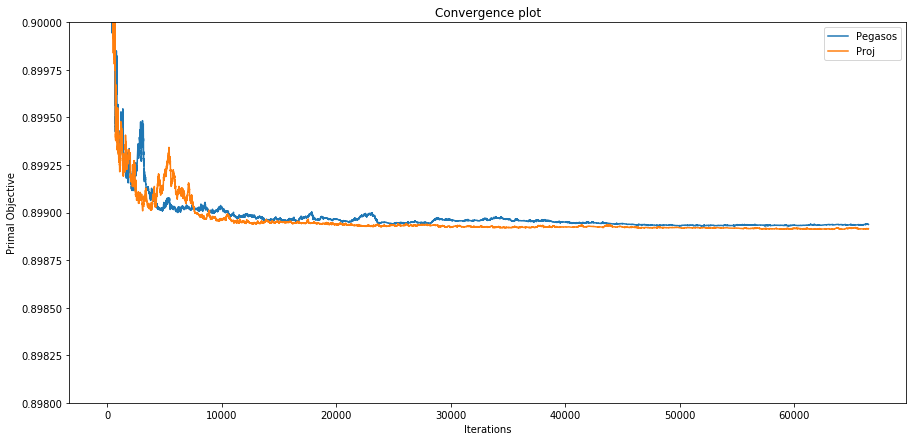

In [43]:
histories_gen_peg = [gen_primal_hist_peg_avg, gen_primal_hist_peg_avg_proj]
labels_gen_peg = ["Pegasos", "Proj"]
comparaison_convergence_plot(histories_gen_peg, labels_gen_peg, ylim=[0.898, 0.9])

In [44]:
# Way more unstable 
# Parameters take a loooong time ton converge compared to SDCA
# The loss takes extremely high values compared to SDCA (max is 200 for SDCA, here it's 700k)
# But a bit faster to converge towards 0

## III.3. Accelerated mini-batch SDCA

In [45]:
gen_opt_w_sdca_batch_avg, gen_w_hist_sdca_batch_avg, gen_primal_hist_sdca_batch_avg = SDCA_SVM_mini_batch(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size = 8, theta = 0.15)

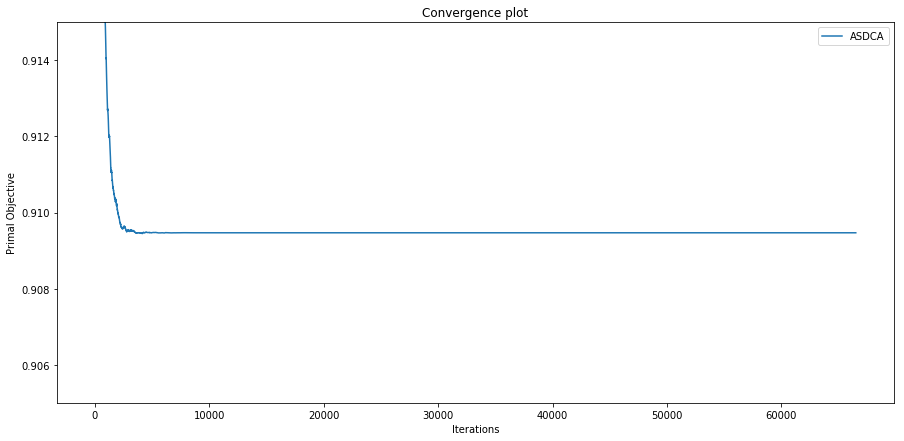

In [46]:
histories_gen_sdca_batch = [gen_primal_hist_sdca_batch_avg]
labels_gen_sdca_batch = ["ASDCA"]
comparaison_convergence_plot(histories_gen_sdca_batch, labels_gen_sdca_batch, ylim=[0.905, 0.915])

## III.4. Mini-batch Pegasos

In [47]:
gen_opt_w_peg_batch_avg, gen_w_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg = PEGASOS_SVM_mini_batch(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, proj=False)
gen_opt_w_peg_batch_avg_proj, gen_w_hist_peg_batch_avg_proj, gen_primal_hist_peg_batch_avg_proj = PEGASOS_SVM_mini_batch(X_res, y_res, n_samples, T_0=50 * n_samples // 2, lambd=50, batch_size=8, proj=False)

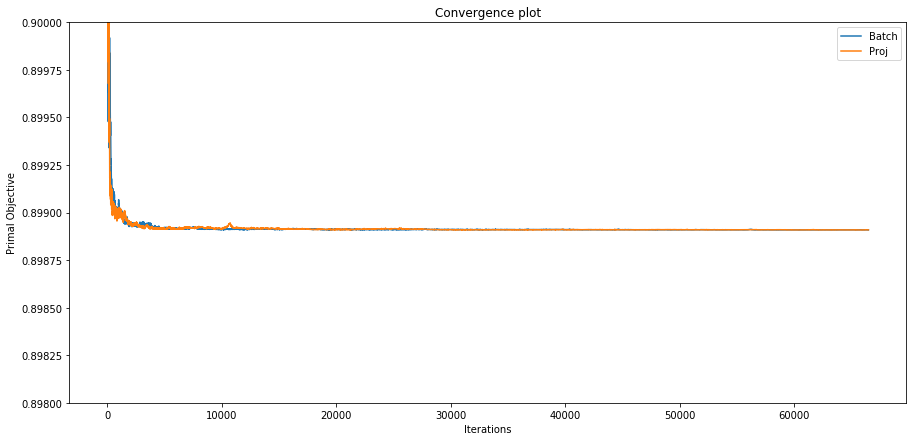

In [48]:
histories_gen_peg_batch = [gen_primal_hist_peg_batch_avg, gen_primal_hist_peg_batch_avg_proj]
labels_gen_peg_batch = ["Batch", "Proj"]
comparaison_convergence_plot(histories_gen_peg_batch, labels_gen_peg_batch, ylim=[0.898, 0.9])

## III.5. Comparision

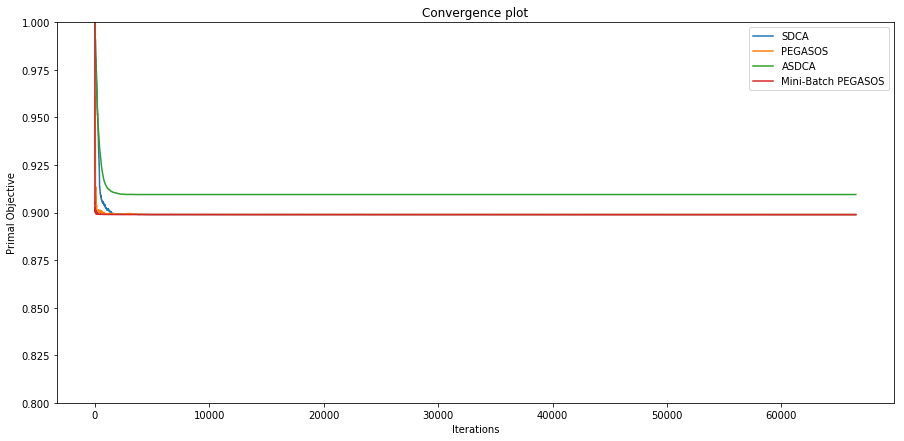

In [49]:
# All simulations
simu_histories = [gen_primal_hist_sdca_avg_r, gen_primal_hist_peg_avg, gen_primal_hist_sdca_batch_avg, gen_primal_hist_peg_batch_avg]
simu_labels = ["SDCA", "PEGASOS", "ASDCA", "Mini-Batch PEGASOS"]
comparaison_convergence_plot(simu_histories, simu_labels, ylim = [0.8, 1])

## III.6 Accuracy

In [50]:
# Computing prediction accuracy on test set
print("SDCA", get_accuracy(X_test, y_test, gen_w_hist_sdca_avg_r[-1]))
print("Pegasos", get_accuracy(X_test, y_test, gen_w_hist_peg_avg[-1]))
print("ASDCA", get_accuracy(X_test, y_test, gen_w_hist_sdca_batch_avg[-1]))
print("Pegasos mini batch", get_accuracy(X_test, y_test, gen_w_hist_peg_batch_avg[-1]))
print("We always predict there is no fraud:", accuracy_score(y_test, np.zeros(y_test.shape[0])-1))

SDCA 0.6483981827273985
Pegasos 0.6534307936203944
ASDCA 0.6465362230946833
Pegasos mini batch 0.6494089608137296
We always predict there is no fraud: 0.9982763573685722
